In [424]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=14)

class CustomIntegrator:
    def __init__(self, F, c0, gamma):
        self.norm_F_squared = np.linalg.norm(F)**2
        self.c0 = c0
        self.gamma = gamma
    
    def c_func(self, t):
        return self.c0 * np.exp(-self.gamma * t)
    
    def c_dot_func(self, t):
        return -self.gamma * self.c_func(t)
    
    def quadratic_w(self, w0, h):
        return w0 / (1 + (w0 * (np.exp(self.gamma * h) - 1) / (2 * self.c0 * self.gamma)))
    
    def linear_w(self, w0, h):
        c = 2 * self.norm_F_squared / self.gamma
        d = w0 - c
        return d * np.exp(-0.5 * self.gamma * h) + c

    def analytical_w(self, w0, h, k = 2):
        w = self.quadratic_w(w0, h/k)
        for i in range(k-1):
            w = self.linear_w(w, h/(k-1))
            w = self.quadratic_w(w, h/k)
        return w

    def ImplicitMidpointStep(self, h, t, Y):
        w0, A, B = Y
        w_mid = self.analytical_w(w0, 0.5 * h)
        k = 0.5 * (-self.gamma - (w_mid / self.c_func(t + 0.5 * h)))
        A_next = A * (1 + 0.5 * h * k) / (1 - 0.5 * h * k)
        B_next = (h + B * (1 + 0.5 * h * k)) / (1 - 0.5 * h * k)
        return np.array([w0, A_next, B_next])
    
    def VectorField(self, t, h, Y):
       t = t + h
       w0, A, B = Y
       c_t = self.c_func(t)
       c_dot_t = self.c_dot_func(t)
       w = self.analytical_w(w0, h)
       dA_dt = ((c_dot_t - w) / (2 * c_t)) * A
       dB_dt = 1 + ((c_dot_t - w) / (2 * c_t)) * B
       return np.array([w0, dA_dt, dB_dt])
    
    def RK4Step(self, h, t, Y):
        k1 = self.VectorField(t, 0, Y)
        k2 = self.VectorField(t, 0.5 * h, Y + 0.5 * h * k1)
        k3 = self.VectorField(t, 0.5 * h, Y + 0.5 * h * k2)
        k4 = self.VectorField(t, h, Y + h * k3)
        Y_next = Y + (h / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
        return Y_next


def A_step(qp, h):
    q, p = qp
    q = q + h * p
    return [q,p]

def B_step(qp, h, c0, gamma, force, t):
    q, p = qp
    F = force(q)
    w0 = np.inner(F, p)
    A0 = 1
    B0 = 0
    Y0 = np.array([w0, A0, B0])
    integrator = CustomIntegrator(F, c0, gamma)
    Y = integrator.ImplicitMidpointStep(h, t, Y0)
    _, A, B = Y[0], Y[1], Y[2]
    p = A * p + B * F
    return [q,p], w0, A, B

def KD_step(q,p,h, c0, gamma, force,t):
    qp = np.copy([q,p])
    #qp, w, A, B = B_step(qp, h/2, c0, gamma, force, t)
    #qp = A_step(qp, h)
    #qp, w, A, B = B_step(qp, h/2, c0, gamma, force, t+h)
    qp = A_step(qp, h/2)
    qp, w, A, B = B_step(qp, h, c0, gamma, force, t)
    qp = A_step(qp, h/2)
    q,p = qp
    return q, p, w, A, B

def isokinetic_optimizer(q0, p0, c0, gamma, Nsteps, h, step_function, force_function):
    q_traj = [np.copy(q0)]
    p_traj = [np.copy(p0)]
    w_traj = [np.inner(force_function(q0), p0)]
    A_traj = [1.]
    B_traj = [0.]
    t_traj = [0]
    q = np.copy(q0)
    p = np.copy(p0)
    t = 0
    for n in range(Nsteps):
        q,p,w,A,B = step_function(q, p, h, c0, gamma, force_function, t)
        t = t + h
        q_traj += [q]
        p_traj += [p]
        w_traj += [w]
        A_traj += [A]
        B_traj += [B]
        t_traj += [t]
    q_traj = np.array(q_traj)
    p_traj = np.array(p_traj)
    w_traj = np.array(w_traj)
    A_traj = np.array(A_traj)
    B_traj = np.array(B_traj)
    t_traj = np.array(t_traj)
    return q_traj, p_traj, w_traj, A_traj, B_traj, t_traj


# Gaussian

In [425]:
def plot_isok(q_traj, p_traj, t_traj, w_traj, A_traj, B_traj, potential, potential_lambda, c_0, gamma, lim = 3):
    fig, axs = plt.subplots(3, 2, figsize=(18, 12))
    x = np.linspace(-lim, lim, 100)
    y = np.linspace(-lim, lim, 100)
    X, Y = np.meshgrid(x, y)
    Z = potential_lambda(X,Y)
    contourf = axs[0][0].contourf(X, Y, Z, levels=np.linspace(0, 9, 10), cmap='viridis', alpha=0.7)
    fig.colorbar(contourf, ax=axs[0][0], label='Potential U(q)')
    _, = axs[0][0].plot(q_traj[:, 0], q_traj[:, 1], lw=1.5, color = 'yellow')
    axs[0][0].set_xlabel('q1')
    axs[0][0].set_ylabel('q2')
    axs[0][0].set_title('Trajectory on Filled Contours of Potential Function')
    axs[0][0].grid(True)
    axs[0][1].plot(t_traj, np.apply_along_axis(potential, axis=1, arr=q_traj))
    axs[0][1].set_xlabel('t')
    axs[0][1].set_ylabel('U(q)')

    axs[1][1].plot(t_traj, c_0 * np.exp(-gamma * t_traj), color = 'green')
    axs[1][1].plot(t_traj, 0.5 * np.linalg.norm(p_traj, axis=1)**2)
    axs[1][1].set_title('Kinetic Energy')
    axs[1][1].set_xlabel('t')
    axs[1][1].set_ylabel('KE')

    axs[1][0].semilogy(t_traj, np.apply_along_axis(potential, axis=1, arr=q_traj)) 
    axs[1][0].set_xlabel('Time')
    axs[1][0].set_ylabel('log U(q)')

    axs[2][0].plot(t_traj, A_traj, label = 'A')
    axs[2][0].plot(t_traj, B_traj, label = 'B')
    axs[2][0].set_xlabel('Time')
    axs[2][0].set_title('A vs B')
    axs[2][0].legend()

    axs[2][1].plot(t_traj, w_traj)
    axs[2][1].set_xlabel('Time')
    axs[2][1].set_ylabel('w')

    plt.tight_layout()
    plt.show()

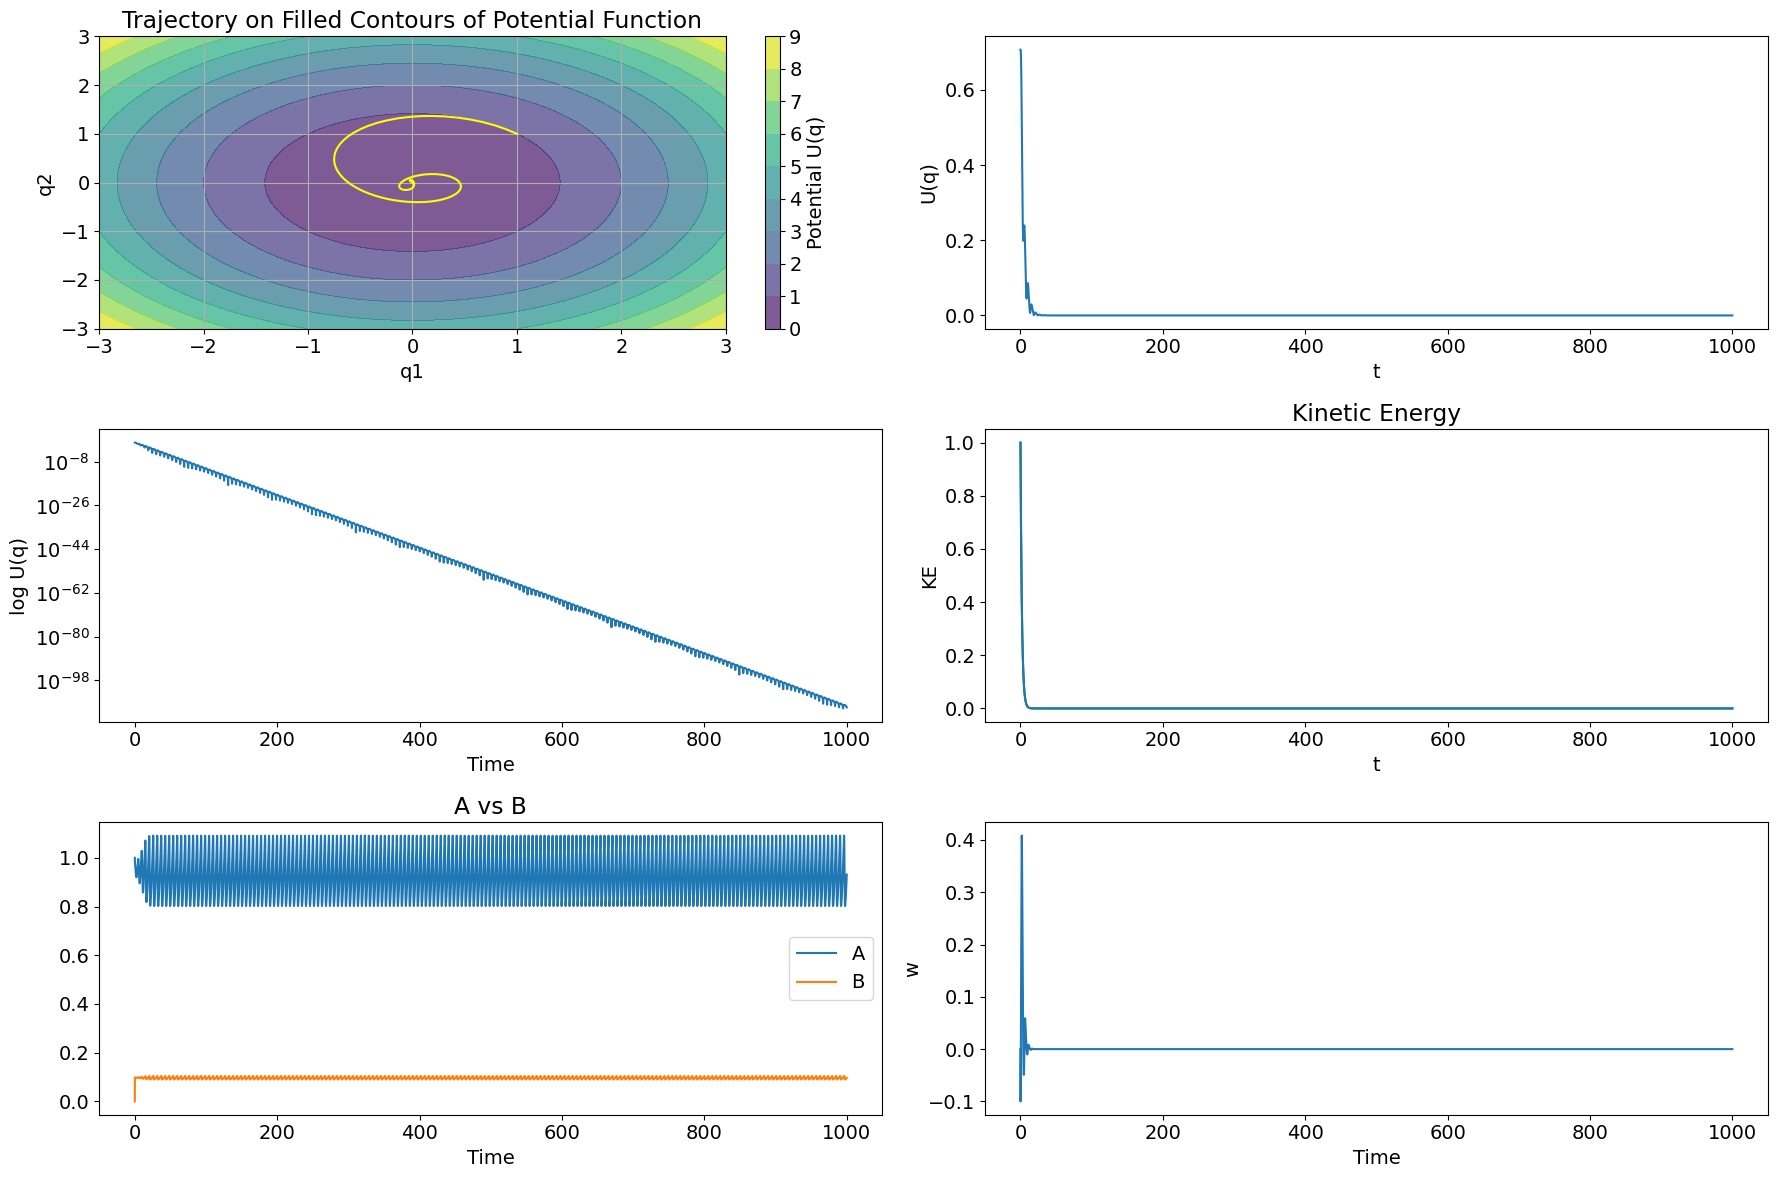

In [426]:
def potential(q):
    return 0.5 * np.linalg.norm(q)

def force_Gaussian(q):
    F = -q
    return F

q0 = np.array([1., 1.])
p0 = np.array([-1., 1.])
Nsteps = 10000
h = 0.1
c0 = 1.0
gamma = 0.5
q_traj, p_traj, w_traj, A_traj, B_traj, t_traj  = isokinetic_optimizer(q0, p0, c0, gamma, Nsteps, h, KD_step, force_Gaussian)
potential_lambda = lambda X,Y: 0.5 * (X**2 + Y**2)
plot_isok(q_traj, p_traj, t_traj, w_traj, A_traj, B_traj, potential, potential_lambda, c0, gamma)

# Super-Quadratic Function

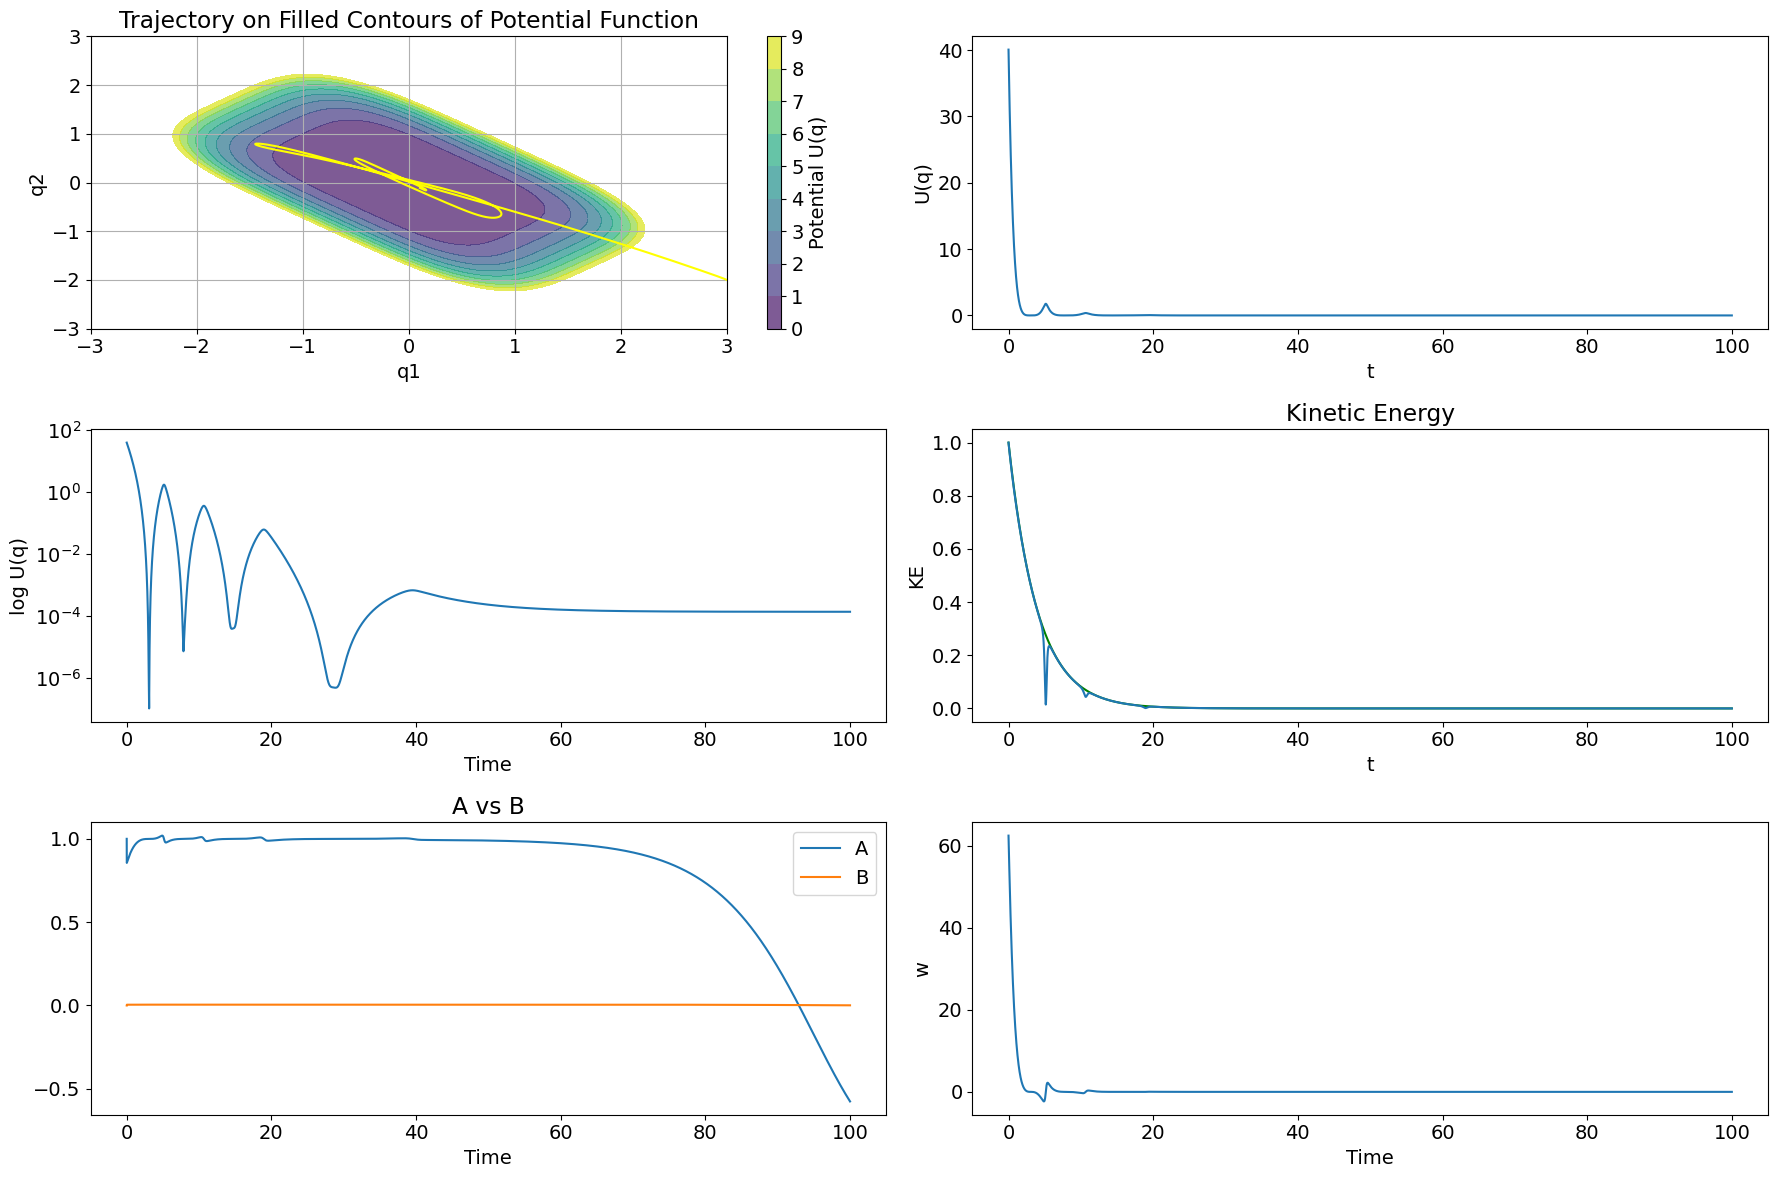

In [423]:
def potential(q):
    return (q[0] + q[1])**4 + (q[0]/2 - q[1]/2)**4

def force_superquadratic(q):
    q0, q1 = q[0], q[1]
    term1 = (q0 + q1)**3
    term2 = (q0 / 2 - q1 / 2)**3
    dq0 = 4 * term1 + 2 * term2
    dq1 = 4 * term1 - 2 * term2
    return -np.array([dq0, dq1])

def hessian(q):
    q0, q1 = q[0], q[1]
    term1 = 12 * (q0 + q1)**2
    term2 = 3 * (q0/2 - q1/2)**2
    
    H11 = term1 + term2
    H12 = term1 - term2
    H21 = H12
    H22 = H11
    
    return np.array([[H11, H12], [H21, H22]])

q0 = np.array([3., -2.])
p0 = np.array([-1., 1.])

Nsteps = 10000
h = 0.01
c0 = 1.0
gamma = 0.25
q_traj, p_traj, w_traj, A_traj, B_traj, t_traj = isokinetic_optimizer(q0, p0, c0, gamma, Nsteps, h, KD_step, force_superquadratic)
potential_lambda = lambda X,Y: (X + Y)**4 + (X/2 - Y/2)**4
plot_isok(q_traj, p_traj, t_traj, w_traj, A_traj, B_traj, potential, potential_lambda, c0, gamma)


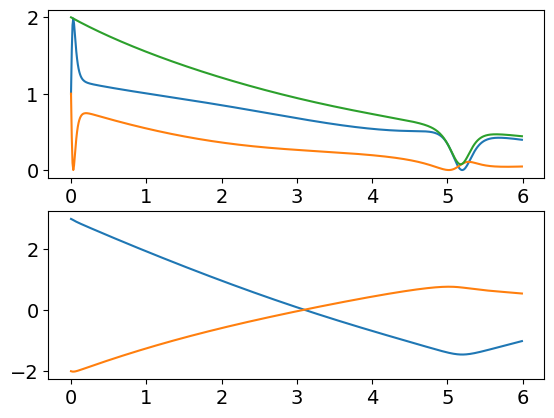

In [366]:
fig, axs = plt.subplots(2,1)
axs[0].plot(t_traj[:600], p_traj[:600,0]**2)
axs[0].plot(t_traj[:600], p_traj[:600,1]**2)
axs[0].plot(t_traj[:600], np.linalg.norm(p_traj[:600], axis=1)**2)
axs[1].plot(t_traj[:600], q_traj[:600,0])
axs[1].plot(t_traj[:600], q_traj[:600,1])

# Himmelbau Function

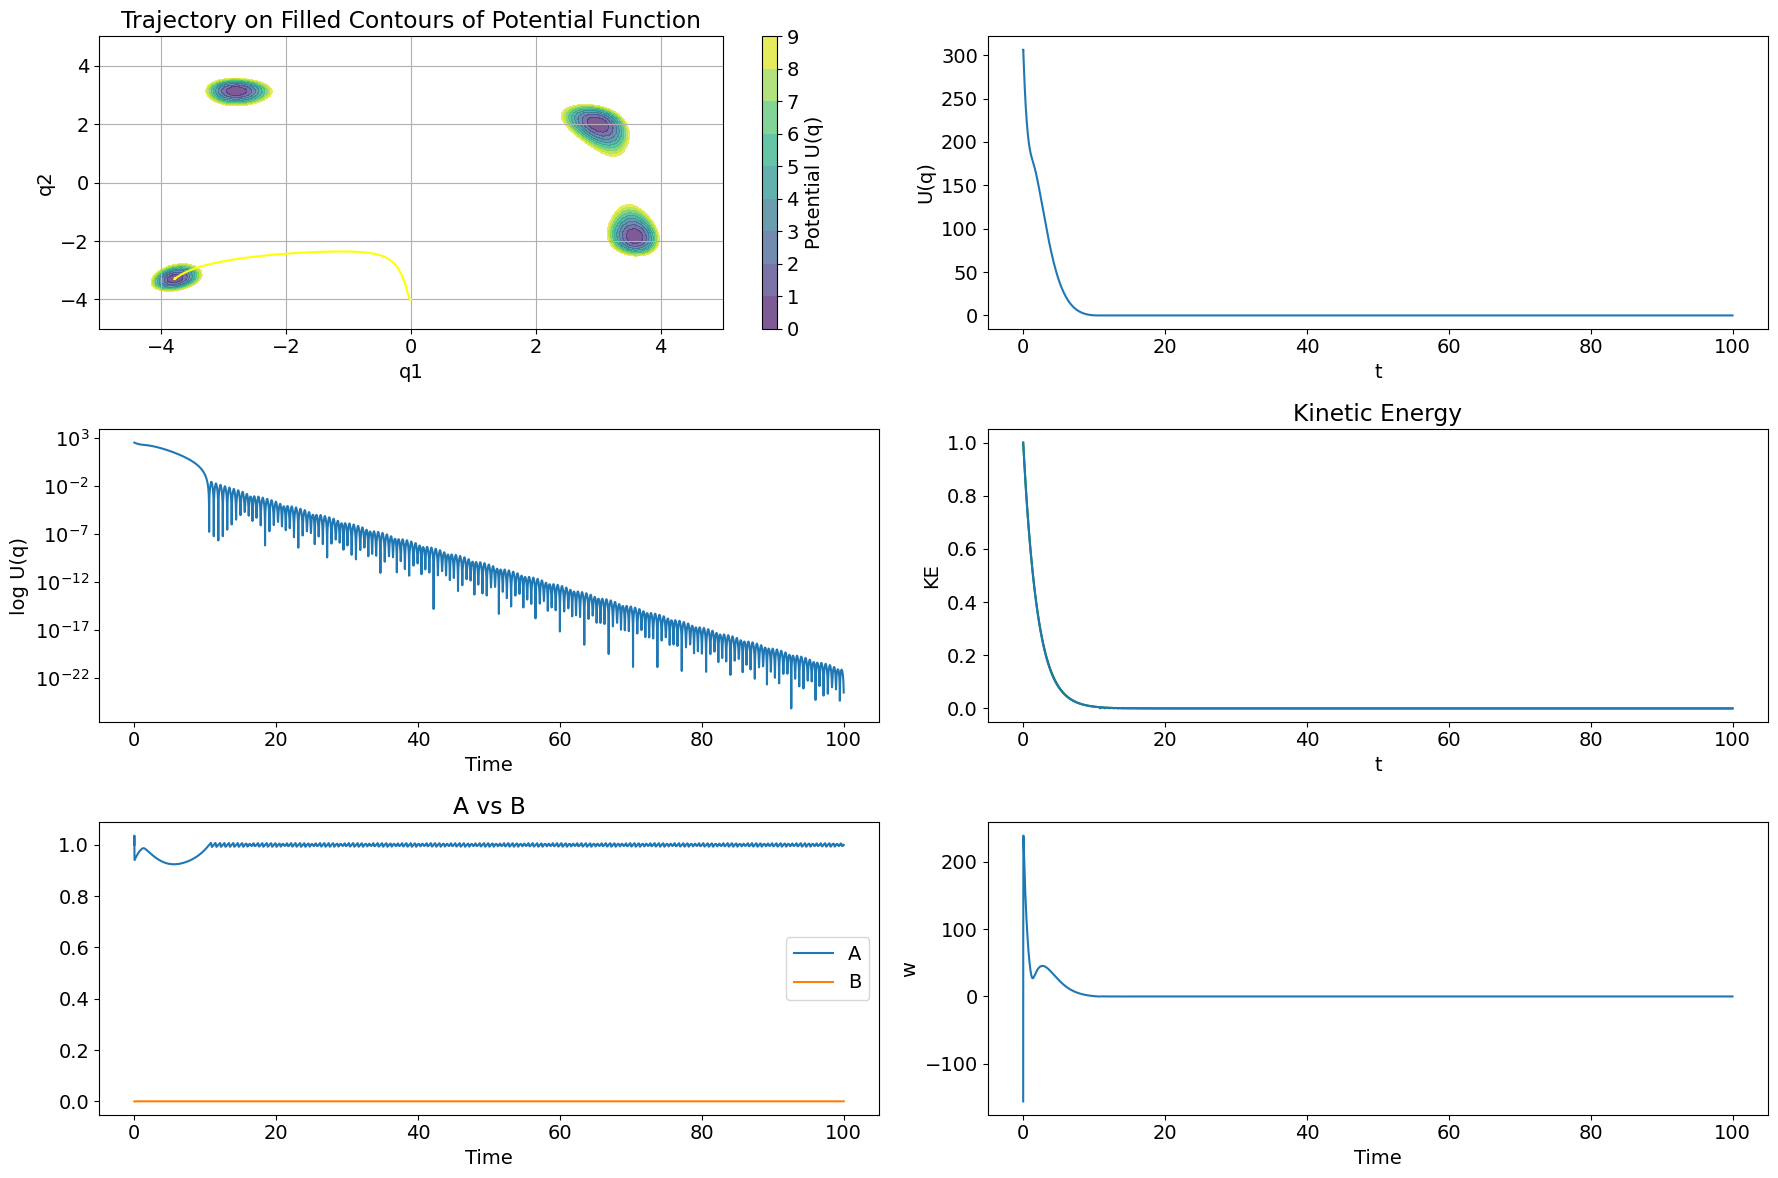

In [377]:
def potential(q):
    x, y = q[0], q[1]
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2


def force_himmelblau(q):
    x, y = q[0], q[1]
    dx = 4 * x * (x**2 + y - 11) + 2 * (x + y**2 - 7)
    dy = 2 * (x**2 + y - 11) + 4 * y * (x + y**2 - 7)
    return -np.array([dx, dy])


q0 = np.array([0, -4.])
p0 = np.array([-1., -1.])

Nsteps = 100000
h = 0.001
c0 = 1.0
gamma = 0.5
q_traj, p_traj, w_traj, A_traj, B_traj, t_traj = isokinetic_optimizer(q0, p0, c0, gamma, Nsteps, h, KD_step, force_himmelblau)
potential_lambda = lambda X,Y: (X**2 + Y - 11)**2 + (X + Y**2 - 7)**2
plot_isok(q_traj, p_traj, t_traj, w_traj, A_traj, B_traj, potential, potential_lambda, c0, gamma, lim = 5)


# Three-Hump Camel

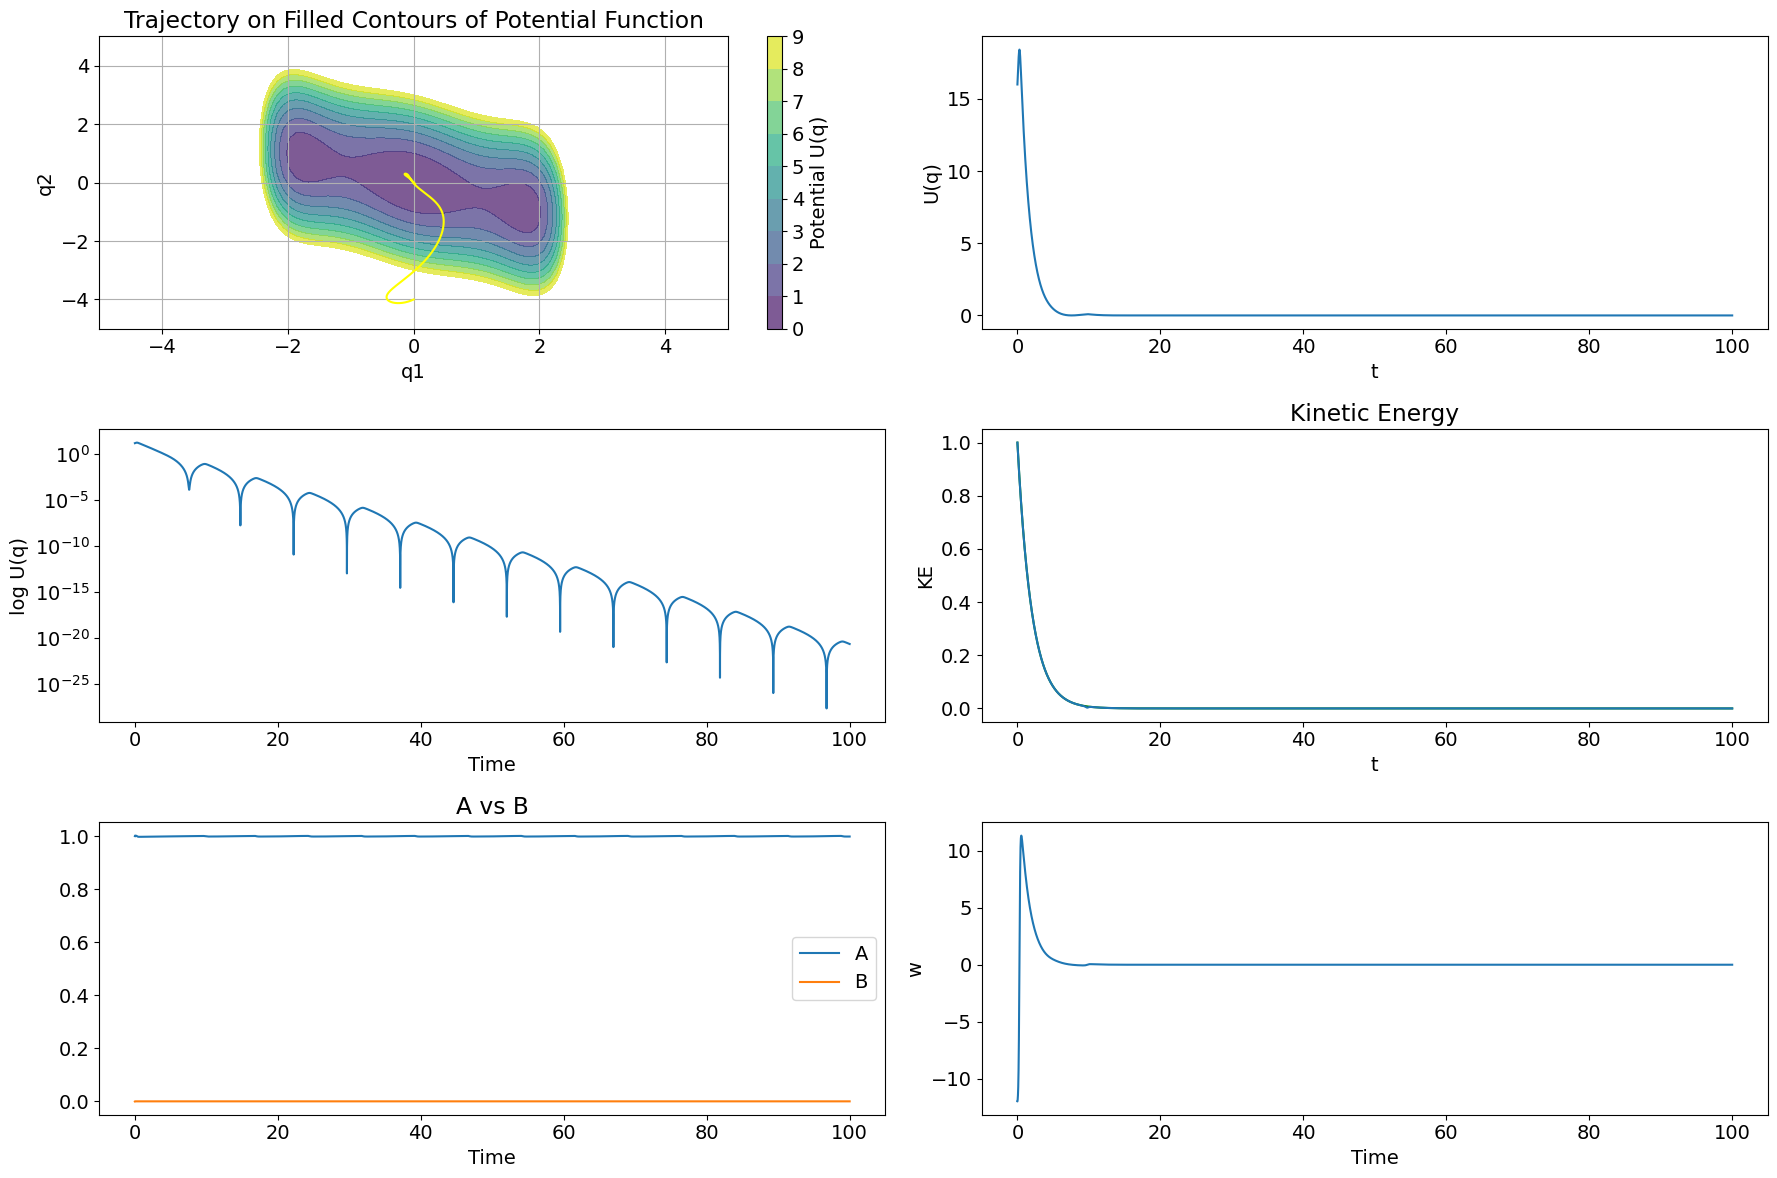

In [262]:
def potential(q):
    x, y = q[0], q[1]
    return 2 * x**2 - 1.05 * x**4 + (x**6) / 6 + x * y + y**2

def force_three_hump_camel(q):
    x, y = q[0], q[1]
    dx = 4 * x - 4.2 * x**3 + x**5 + y
    dy = x + 2 * y
    return -np.array([dx, dy])

q0 = np.array([0, -4.])
p0 = np.array([-1., -1.])

Nsteps = 100000
h = 0.001
c0 = 1.0
gamma = 0.5
q_traj, p_traj, w_traj, A_traj, B_traj, t_traj = isokinetic_optimizer(q0, p0, c0, gamma, Nsteps, h, KD_step, force_three_hump_camel)
potential_lambda = lambda X,Y: 2 * X**2 - 1.05 * X**4 + (X**6) / 6 + X * Y + Y**2
plot_isok(q_traj, p_traj, t_traj, w_traj, A_traj, B_traj, potential, potential_lambda, c0, gamma, lim = 5)

# Beale Function

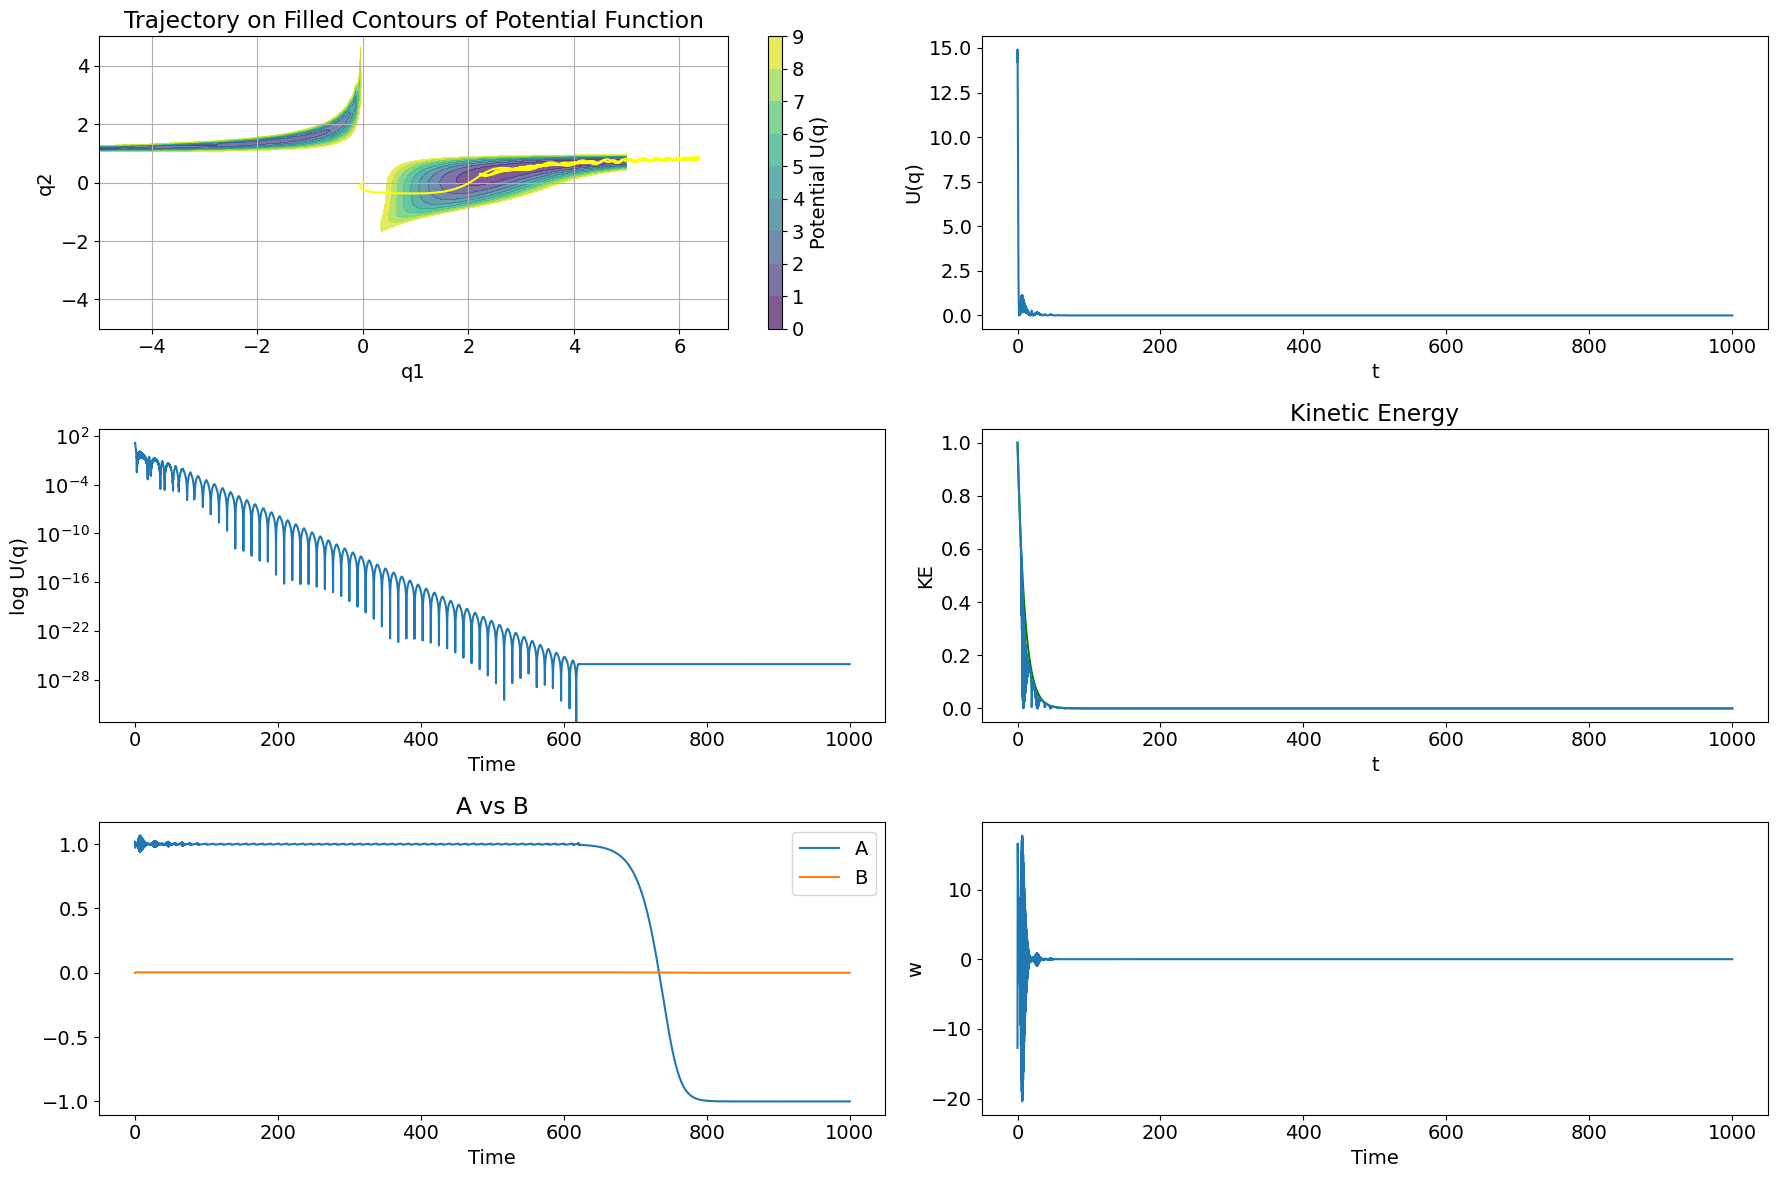

In [285]:
def potential(q):
    x, y = q[0], q[1]
    return (1.5 - x + x * y)**2 + (2.25 - x + x * y**2)**2 + (2.625 - x + x * y**3)**2

def force_beale(q):
    x, y = q[0], q[1]
    dx = 2 * (1.5 - x + x * y) * (-1 + y) + 2 * (2.25 - x + x * y**2) * (-1 + y**2) + 2 * (2.625 - x + x * y**3) * (-1 + y**3)
    dy = 2 * (1.5 - x + x * y) * x + 4 * (2.25 - x + x * y**2) * x * y + 6 * (2.625 - x + x * y**3) * x * y**2
    return -np.array([dx, dy])

q0 = np.array([0.0, 0.0])
p0 = np.array([-1.0, -1.0])

Nsteps = 100000
h = 0.01
c0 = 1.0
gamma = 0.1
q_traj, p_traj, w_traj, A_traj, B_traj, t_traj = isokinetic_optimizer(q0, p0, c0, gamma, Nsteps, h, KD_step, force_beale)
potential_lambda = lambda X, Y: (1.5 - X + X * Y)**2 + (2.25 - X + X * Y**2)**2 + (2.625 - X + X * Y**3)**2
plot_isok(q_traj, p_traj, t_traj, w_traj, A_traj, B_traj, potential, potential_lambda, c0, gamma, lim=5)

# Matyas Function

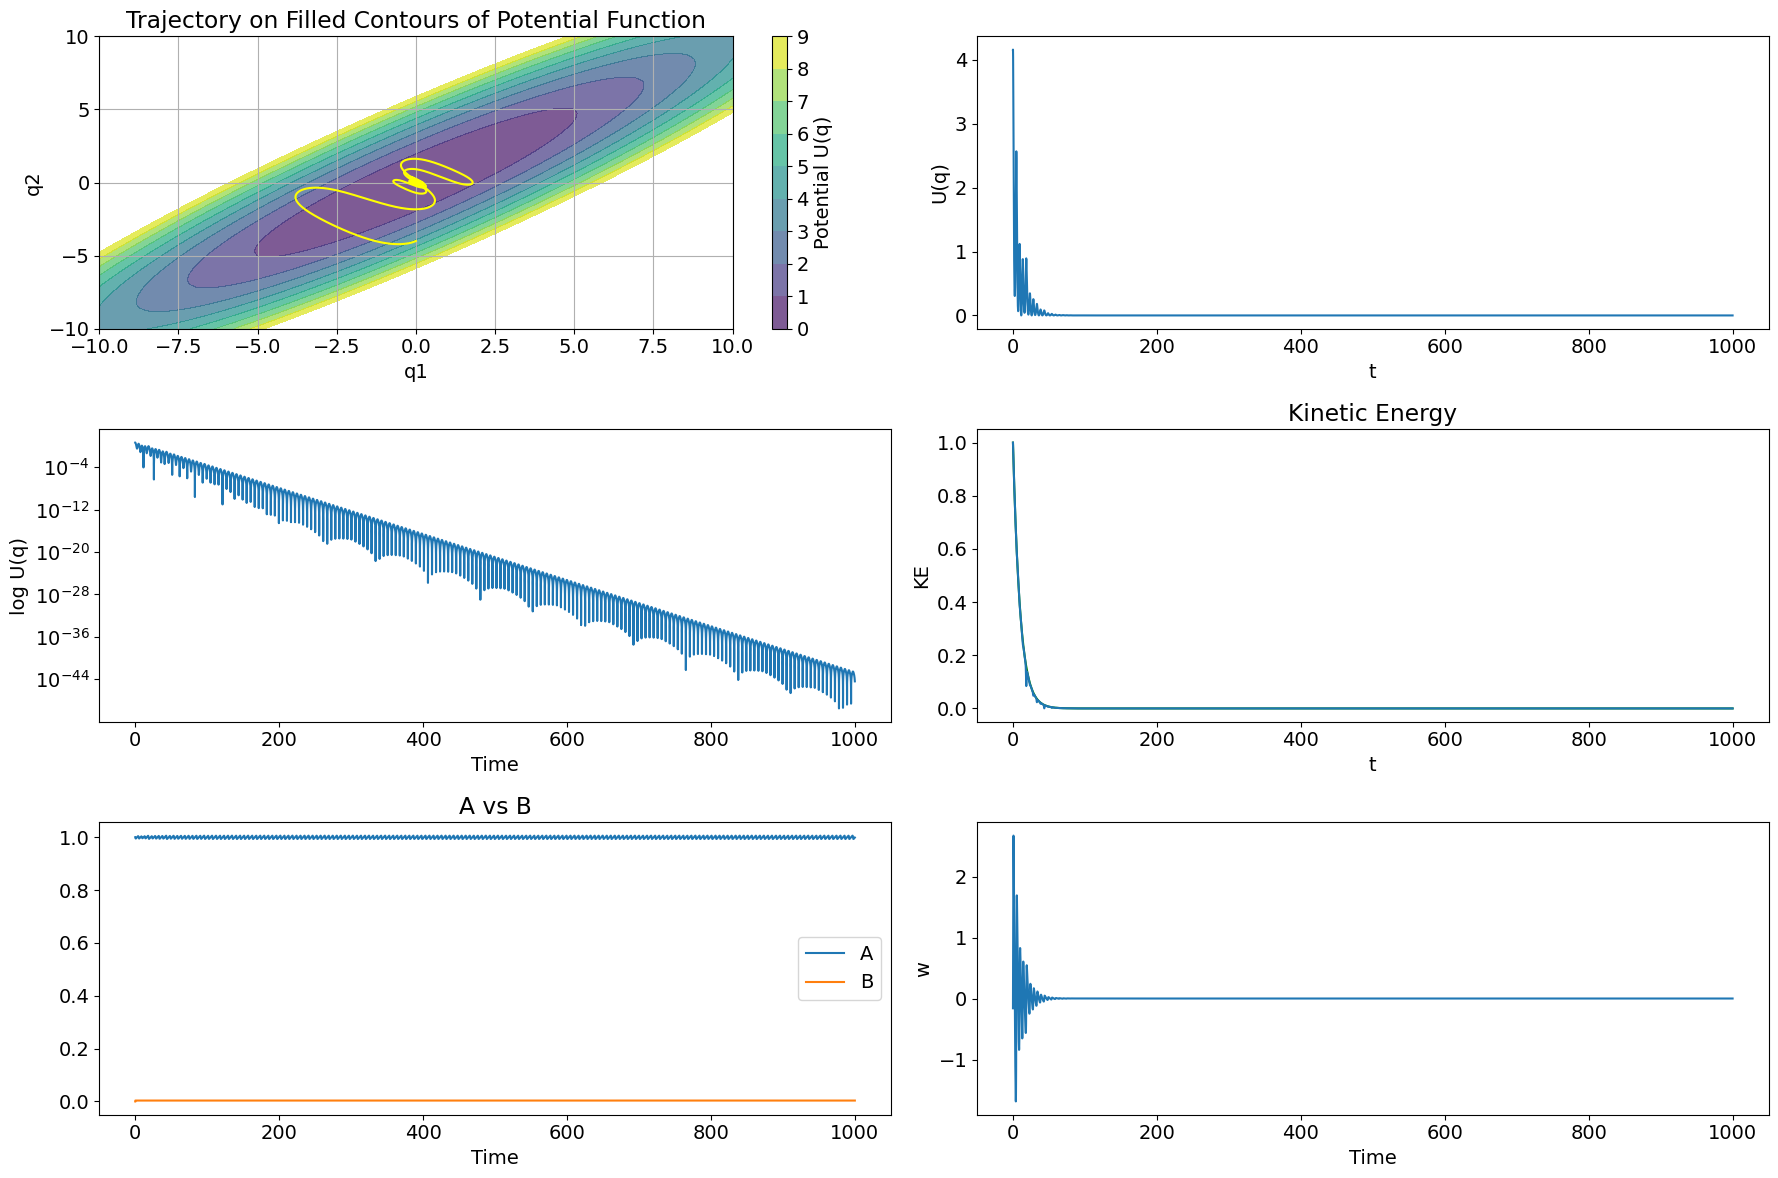

In [284]:
def potential(q):
    x, y = q[0], q[1]
    return 0.26 * (x**2 + y**2) - 0.48 * x * y

def force_matyas(q):
    x, y = q[0], q[1]
    dx = 0.52 * x - 0.48 * y
    dy = 0.52 * y - 0.48 * x
    return -np.array([dx, dy])

q0 = np.array([0.0, -4.0])
p0 = np.array([-1.0, -1.0])

Nsteps = 100000
h = 0.01
c0 = 1.0
gamma = 0.1
q_traj, p_traj, w_traj, A_traj, B_traj, t_traj = isokinetic_optimizer(q0, p0, c0, gamma, Nsteps, h, KD_step, force_matyas)
potential_lambda = lambda X, Y: 0.26 * (X**2 + Y**2) - 0.48 * X * Y
plot_isok(q_traj, p_traj, t_traj, w_traj, A_traj, B_traj, potential, potential_lambda, c0, gamma, lim=10)

# Rosenbrock

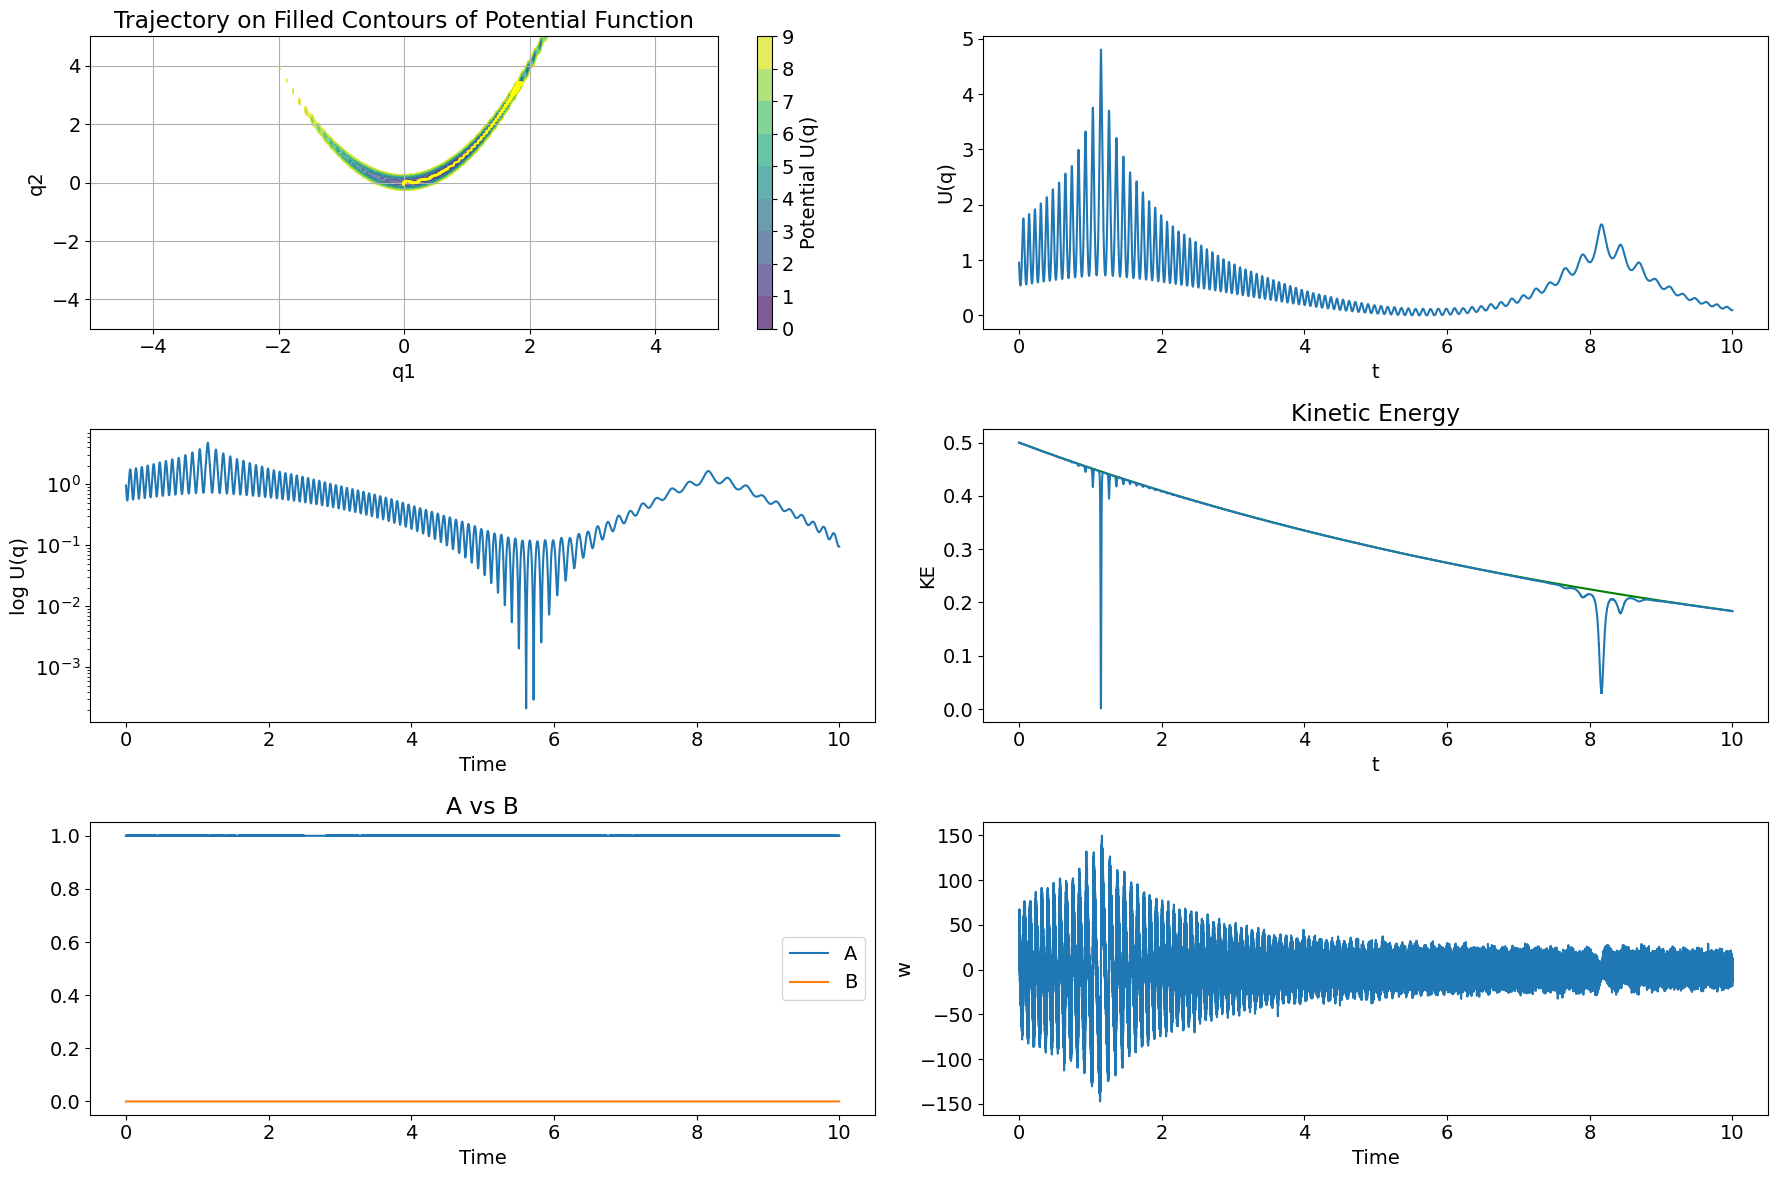

In [355]:
def potential(q):
    return 100 * (q[1] - q[0]**2)**2 + (1 - q[0])**2


def force_rosenbrock(q):
    q0, q1 = q[0], q[1]
    dq0 = -400 * q0 * (q1 - q0**2) - 2 * (1 - q0)
    dq1 = 200 * (q1 - q0**2)
    return -np.array([dq0, dq1]) + 10. * np.random.randn(2)


q0 = np.array([1.75, 3.])
p0 = np.array([-1., 1.]) / np.sqrt(2)

Nsteps = 1000000
h = 0.00001
c0 = 0.5
gamma = 0.1
q_traj, p_traj, w_traj, A_traj, B_traj, t_traj = isokinetic_optimizer(q0, p0, c0, gamma, Nsteps, h, KD_step, force_rosenbrock)
potential_lambda = lambda X,Y: 100 * (Y - X**2)**2 + (1 - X)**2
plot_isok(q_traj, p_traj, t_traj, w_traj, A_traj, B_traj, potential, potential_lambda, c0, gamma, lim=5)